In [68]:
import numpy as np
import copy

L = 1000 # максимальный опыт уровня
n_param = 10

# Текущий баланс + {n}% от расходов
def effect_11_1(ag):
    ag.balance += ag.expense*n_param/100

# + {n}% к опыту от текущего опыта
def effect_11_2(ag):
    ag.update_xp(ag.xp*n_param/100)

# Текущий расход - {n} единиц условной валюты
def effect_30(ag):
    ag.update_expense(-n_param)

# Текущий доход + {n}% от баланса
def effect_32_1(ag):
    ag.income += ag.balance*n_param/100

# Текущий баланс + {n}% от дохода
def effect_32_2(ag):
    ag.balance += ag.income*n_param/100

# Текущий баланс + {n} единиц условной валюты
def effect_49_1(ag):
    ag.balance += n_param

# + {n}% к опыту от максимального опыта уровня
def effect_49_2(ag):
    ag.update_xp(L*n_param/100)

# Текущий доход + {n}% от расходов
def effect_49_3(ag):
    ag.income += ag.expense*n_param/100

artefacts = {
    # увеличение баланса и опыта
    11: [ 300,
        [-1, effect_11_1], # до следующего аукциона
        [n_param, effect_11_2]
    ],
    # уменьшение расходов
    30: [ 200,
        [n_param, effect_30]
    ],
    # увеличение баланса и доходов, уменьшение расходов
    32: [ 500,
        [1, effect_32_1],
        [1, effect_32_2],
        [n_param, effect_30]
    ],
    # увеличение опыта
    35:[ 100,
        [n_param, effect_11_2]
    ],
    # увеличение баланса, опыта и дохода
    49:[ 400,
        [1, effect_49_1],
        [1, effect_49_2],
        [n_param, effect_49_3]
    ]
}

In [69]:

class Agent:
    def __init__(self, ind, balance, income, expense, level=0, xp=0):
        self.ind = ind
        self.level = level
        self.xp = xp
        self.balance = balance
        self.income = income
        self.expense = expense
        self.effects = []
    

    def update_income(self, new):
        self.income = max(0, self.income+new)
    
    def update_expense(self, new):
        self.expense = max(0, self.expense+new)

    def update_effects(self):
        i = 0
        while i < len(self.effects):
            self.effects[i][0] -= 1
            # print(self.effects[i])
            t, f = self.effects[i]
            f(self)
            if not t:
                self.effects.pop(i)
            else:
                i += 1
        return (self.level >= 10)
    
    # сделать ставку
    def bet(self, art_id, price, effects, verbose=0):

        if price > self.balance:
            return -1
        
        # стоимость минус половина остатка
        new_balance = (self.balance-price)/2

        temp_agent = Agent(0, new_balance, self.income, self.expense, self.level, self.xp)
        temp_agent.effects = copy.deepcopy(effects)
        while temp_agent.effects:
            temp_agent.update_effects()
            flag = temp_agent.update_balance()
            if flag:
                break
        if verbose==2:
            print('tempBalance:', new_balance)
            print(temp_agent)
            print('Flag:', flag)

        f1 = new_balance / (temp_agent.balance if temp_agent.balance else 1)
        f2 = self.income / (temp_agent.income if temp_agent.income else 1)
        f3 = temp_agent.expense / (self.expense if self.expense else 1)
        f4 = temp_agent.level - self.level
        f5 = (f4*L + temp_agent.xp - self.xp)/(L*10)

        if verbose==2:
            print('Balance:', f1)
            print(1/f1)
            print('income:', f2)
            print('expense:', f3)
            print('level:', f4)
            print('xp:', f5)

        coef = -1
        
        if flag == 1:
            coef = 1
        elif art_id in [11, 35]:
            coef = max(f5, 0)
        elif art_id == 30:
            if not self.expense:
                coef = 1 - f1
            else:
                coef = 1 - f3
        elif art_id in [32, 49]:
            coef = max(1-f2, 1-f3)
        
        bet = -1
        if coef != -1:
            bet = price + new_balance*coef
        return bet

        
        
        
    def update_balance(self):
        prev = self.balance
        self.balance += self.income - self.expense
        if self.balance < 0:
            return -1 # проигрыш
        
        return self.update_xp(self.balance-prev)
    
    def update_xp(self, new):
        self.xp = max(0, self.xp + new)
        if self.xp >= L:
            self.level += self.xp // L
            self.xp %= L
        
        return (self.level >= 10) # 1 - выигрыш, 0 - продолжаем

    def __repr__(self):
        return f"({self.level})Agent{self.ind}, xp={self.xp}, balance={self.balance}, {self.income}/{self.expense}"
        


In [83]:

T = 1000


def gen_event(agents, g, j, verbose=0):
    flag = np.random.randint(2) # 1 - буря, 0 - ренессанс
    if flag:
        g *= -1
        j *= -1
    
    if verbose:
        print(f"Событие: {['Ренессанс', 'Буря'][flag]}")
    for a in agents:
        a.update_income(g)
        a.update_expense(-j)

def gen_auction(agents, t_a, verbose=0):
    art_id = np.random.choice(list(artefacts.keys()), 1)[0]
    price, *effects = copy.deepcopy(artefacts[art_id])
    if art_id == 11:
        effects[0][0] = t_a    
    
    # однораундовый аукцион
    flag = np.random.choice(2) # первой или второй цены
    
    bets = []
    for i in range(len(agents)):
        t = agents[i].bet(art_id, price, effects, verbose)
        if t != -1:
            bets.append((i, t))
    
    if not bets:
        return
    
    bets.sort(key=lambda x: x[1], reverse=True)
    if flag and len(bets)>1: # аукцион второй цены
        winner_id = bets[0][0]
        winner_price = bets[1][1]
    else: # аукцион первой цены
        winner_id, winner_price = bets[0]
    
    winner = agents[winner_id]
    winner.balance -= winner_price
    if verbose:
        print(f'Агент{winner.ind} получает артефакт {art_id} за {winner_price}')
    winner.effects.extend(effects)



def sim(n, B, t_a, t_e, g, j, verbose=0):
    agents = []
    times = []
    for i in range(n):
        income = np.random.randint(10, 15)
        expense = np.random.randint(5, 10)
        agents.append(Agent(i, B, income, expense))
    
    auction = t_a
    event = t_e
    for t in range(T):

        # применение эффектов и обновление баланса
        i = 0
        while i < len(agents):
            agents[i].update_effects()
            flag = agents[i].update_balance()
            if flag:
                a = agents.pop(i)
                if verbose:
                    if flag == -1:
                        print(f"Agent{a.ind} проиграл")
                    else:
                        print(f"Agent{a.ind} выиграл")
                    print(a)
                if flag == -1:
                    times.append(t)
            else:
                i += 1
        
        if not agents:
            break

        if not event:
            event = t_e
            gen_event(agents, g, j, verbose)
        
        if not auction:
            auction = t_a
            gen_auction(agents, t_a, verbose)
        
        event -= 1
        auction -= 1
    
    return t, times



In [86]:

sim(10, 400, 10, 14, 4, 4, verbose=1)

Агент1 получает артефакт 49 за 413.0263157894737
Событие: Буря
Агент3 получает артефакт 35 за 105.30644520802595
Событие: Буря
Агент4 получает артефакт 49 за 437.55555555555554
Агент3 получает артефакт 11 за 300.0
Событие: Ренессанс
Агент6 получает артефакт 30 за 304.0
Событие: Ренессанс
Событие: Буря
Агент4 получает артефакт 35 за 110.72249448215847
Агент1 получает артефакт 30 за 386.61097498114304
Событие: Буря
Агент4 получает артефакт 30 за 427.61097498114304
Событие: Буря
Agent5 проиграл
(0)Agent5, xp=0, balance=-7, 0/19
Агент1 получает артефакт 30 за 381.8813546146911
Agent2 проиграл
(0)Agent2, xp=0, balance=-3, 2/21
Agent9 проиграл
(0)Agent9, xp=0, balance=-15, 0/18
Agent3 проиграл
(0)Agent3, xp=687.7033548034856, balance=-8.506445208025951, 2/17
Agent7 проиграл
(0)Agent7, xp=0, balance=-6, 0/18
Агент4 получает артефакт 32 за 518.3054874905715
Событие: Ренессанс
Agent0 проиграл
(0)Agent0, xp=0, balance=-1, 5/14
Agent8 проиграл
(0)Agent8, xp=0, balance=-1, 4/13
Агент1 получает арт

(370, [99, 104, 105, 106, 110, 120, 120])

In [4]:
# income = 0
# expense = np.random.randint(10,20)
# ag = Agent(0, B, income, expense, xp=500)
# print(ag)
# for k,v in artefacts.items():
#     if k == 11:
#         continue
#     print("Artefact:", k)
#     print()
#     price, *effects = copy.deepcopy(v)
#     print("Bet:", ag.bet(k, price, effects, verbose=2))
#     print()

# полезность можно считать как отношение дохода к расходу. Также на основаниии этого можно и ставки делать.
# для артефакта с xp уже надо считать нужно ли это агенту или бесполезно.

# ставку можно составлять из половины остаточной суммы и масштабировать по полезности
# для 35, например, учитываем проигрыш по балансу, но также и выигрыш по хp (надо пересмотреть метрику xp)
# полезность по доходу будем считать как 1 - отношение старого к новому доходу 
# аналогично можно считать и по расходу, а там уже брать максимум

def get_disrtib(n, B, t_a, t_e, g, j, iters):
    P = [0]*T

    k = 0
    for _ in range(iters):
        t, times = sim(n, B, t_a, t_e, g, j, verbose=0)
        k += len(times)
        for i in times:
            P[i] += 1
    
    for i in range(1, T):
        if k:
            P[i] /= k
        P[i] += P[i-1]
    
    return P

In [88]:
import pandas as pd

params = {
    "n" : [2, 5, 10, 20, 50, 100],
    "B" : [100, 300, 500, 800, 1000, 2000],
    "t_a" : [2, 5, 10, 20, 50, 100],
    "t_e" : [2, 5, 10, 20, 50, 100],
    "g" : [2, 4, 6, 10, 15, 20],
    "j" : [2, 4, 6, 10, 15, 20]
    }

In [ ]:
columns = ['n', 'B', 't_a', 't_e', 'g', 'j', 'P']

data = []
for n in params['n']:
    print(n)
    for B in params['B']:
        for t_a in params['t_a']:
            for t_e in params['t_e']:
                for g in params['g']:
                    for j in params['j']:
                        P = get_disrtib(n, B, t_a, t_e, g, j, 1)
                        data.append((n,B,t_a,t_e,g,j,P))

df = pd.DataFrame(data, columns=columns)
df

2
5
10
20
50
100


,n,B,t_a,t_e,g,j,P
0,2,100,2,2,2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,100,2,2,2,4,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,2,100,2,2,2,6,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
3,2,100,2,2,2,10,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
4,2,100,2,2,2,15,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
...,...,...,...,...,...,...,...
46651,100,2000,100,100,20,4,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
46652,100,2000,100,100,20,6,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
46653,100,2000,100,100,20,10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
46654,100,2000,100,100,20,15,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."


In [6]:
df = pd.read_csv('data.csv')

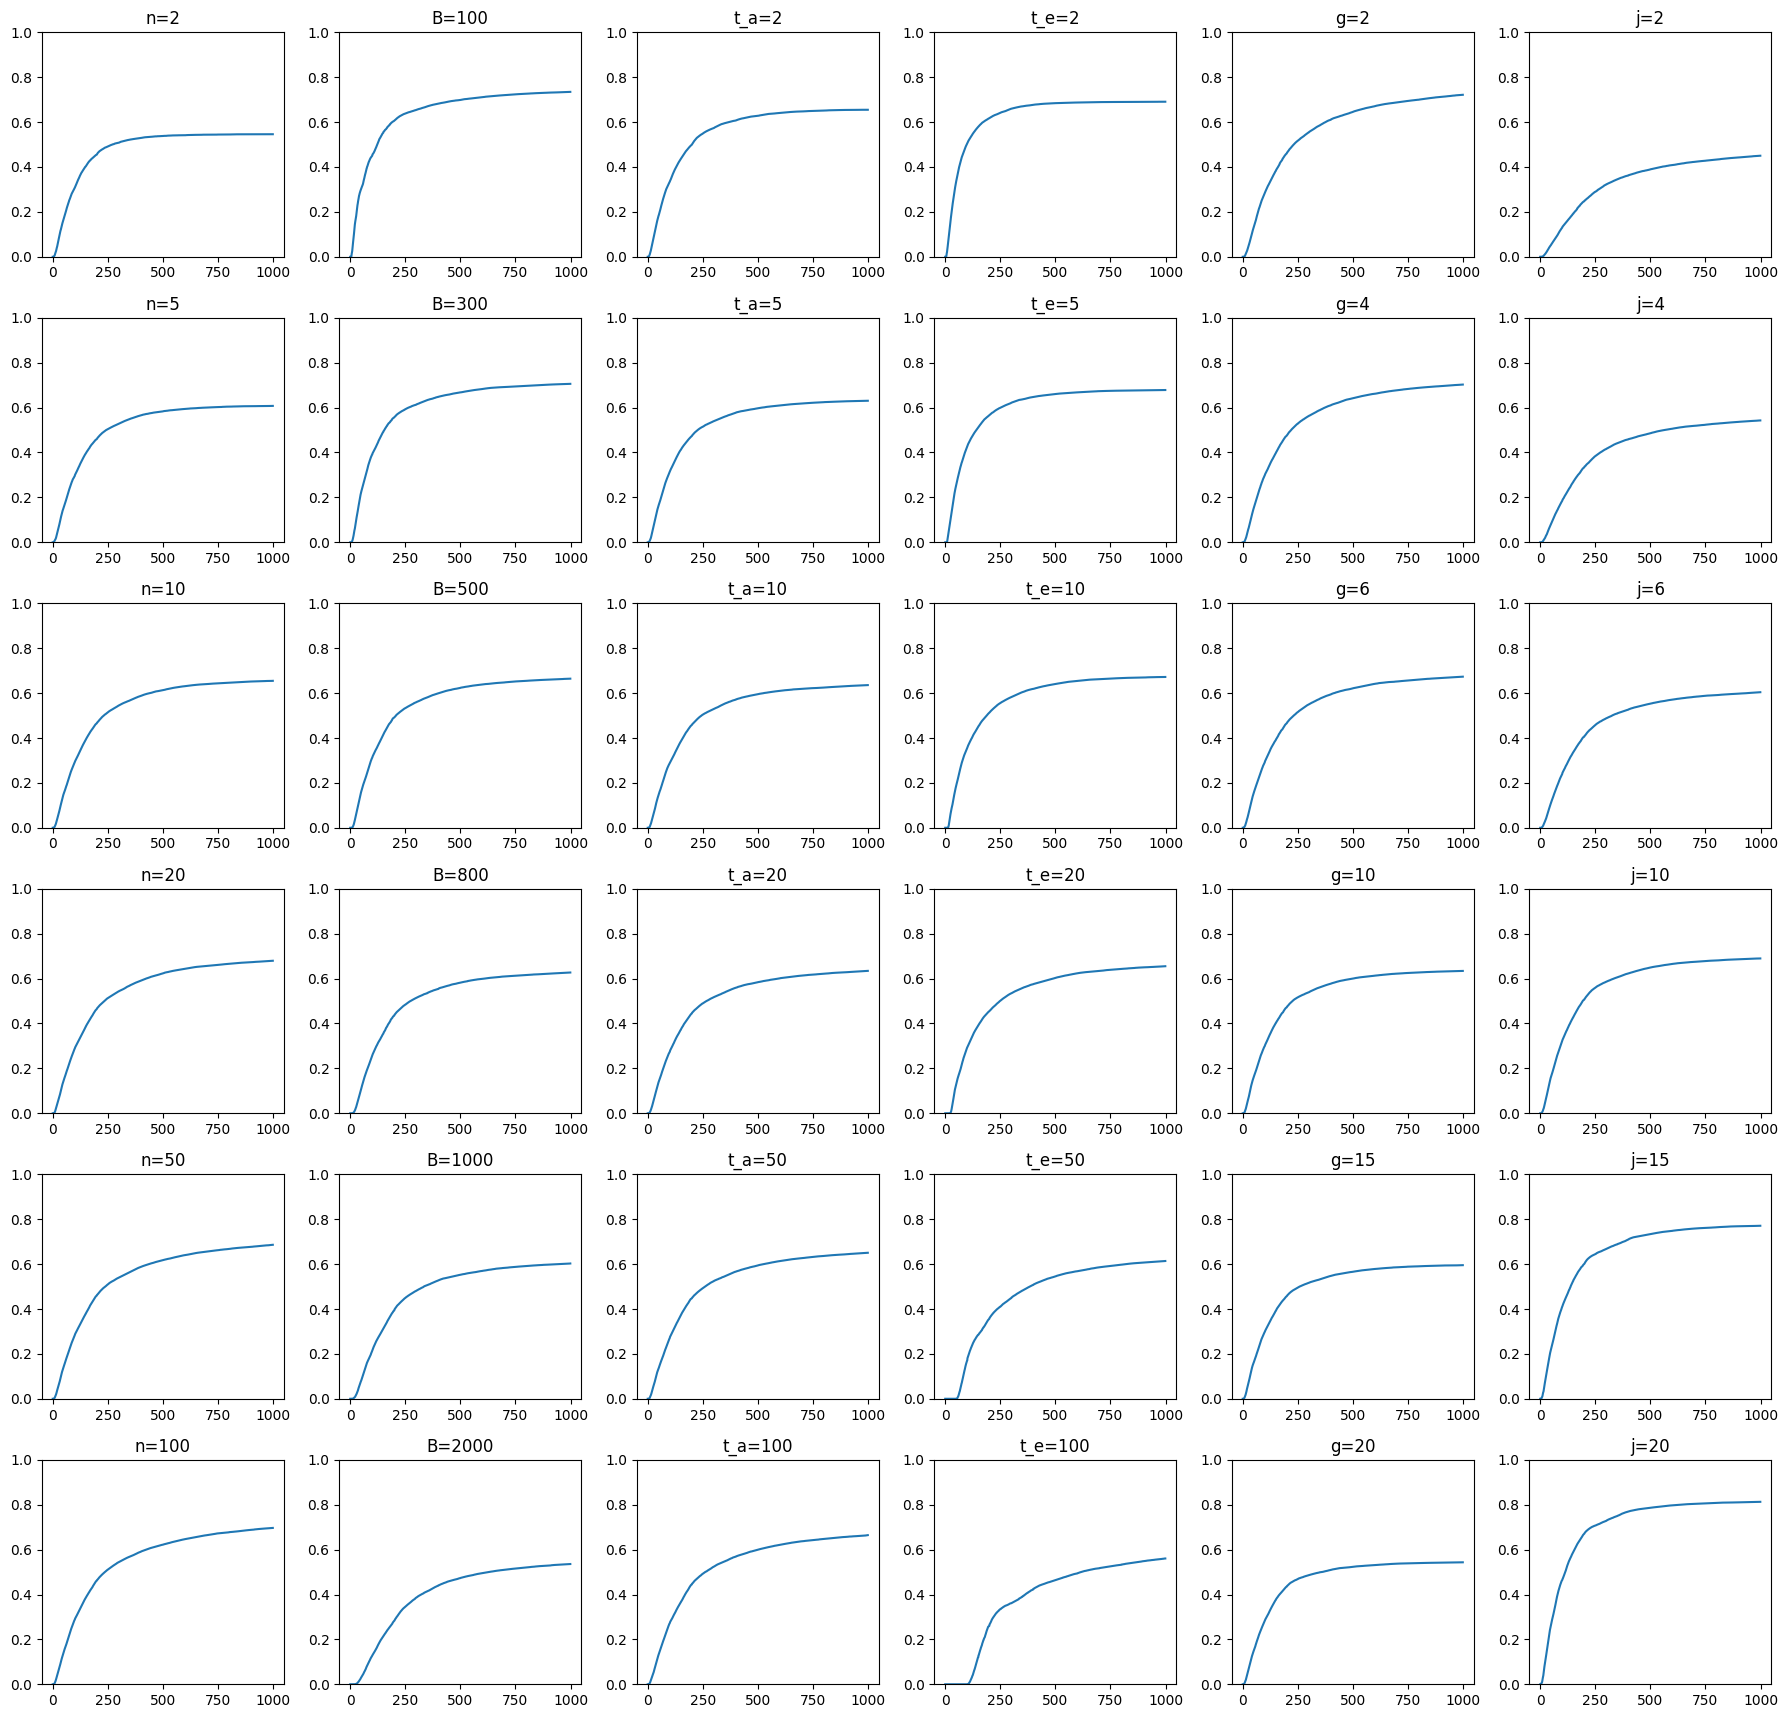

In [56]:

import matplotlib.pyplot as plt

params = {
    "n" : [2, 5, 10, 20, 50, 100],
    "B" : [100, 300, 500, 800, 1000, 2000],
    "t_a" : [2, 5, 10, 20, 50, 100],
    "t_e" : [2, 5, 10, 20, 50, 100],
    "g" : [2, 4, 6, 10, 15, 20],
    "j" : [2, 4, 6, 10, 15, 20]
    }



fig, axs = plt.subplots(6, 6, figsize=(18, 18))

def display(p_i):
    params_names = ['n', 'B', 't_a', 't_e', 'g', 'j']

    for i in range(6):
        p_name = params_names[p_i]
        Ps = df[df[p_name]==params[p_name][i]]['P'].array
        P = np.zeros(T)
        for j in range(len(Ps)):
            P += np.array(list(map(float, Ps[j][1:-1].split(', '))))
        P/=len(Ps)
        axs[i, p_i].plot(P)
        axs[i, p_i].set_title(f'{p_name}={params[p_name][i]}')
        axs[i, p_i].set_ylim(0,1)

for p_i in range(6):
    display(p_i)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [114]:
params = {
    "n" : [5, 10, 20, 40],
    "B" : [100, 500, 1000, 2000],
    "t_a" : [5, 10, 50, 100],
    "t_e" : [5, 10, 50, 100],
    "g" : [4, 10, 15, 20],
    "j" : [4, 10, 15, 20]
    }

In [115]:
columns = ['n', 'B', 't_a', 't_e', 'g', 'j', 'P']

data2 = []
k = 10
for n in params['n']:
    print(n)
    for B in params['B']:
        for t_a in params['t_a']:
            for t_e in params['t_e']:
                for g in params['g']:
                    for j in params['j']:
                        prob = 0
                        for i in range(k):
                            t, times = sim(n, B, t_a, t_e, g, j)
                            # вероятность выигрыша
                            prob += (n-len(times))/n
                        prob /= k
                        data2.append((n,B,t_a,t_e,g,j,prob))

df2 = pd.DataFrame(data2, columns=columns)
df2

5
10
20
40


,n,B,t_a,t_e,g,j,P
0,5,100,5,5,4,4,0.2200
1,5,100,5,5,4,10,0.1000
2,5,100,5,5,4,15,0.3800
3,5,100,5,5,4,20,0.2800
4,5,100,5,5,10,4,0.3800
...,...,...,...,...,...,...,...
4091,40,2000,100,100,15,20,0.3575
4092,40,2000,100,100,20,4,0.6275
4093,40,2000,100,100,20,10,0.6100
4094,40,2000,100,100,20,15,0.5150


In [116]:
df2[df2['n']==10]['P'].mean()

0.45209960937500004

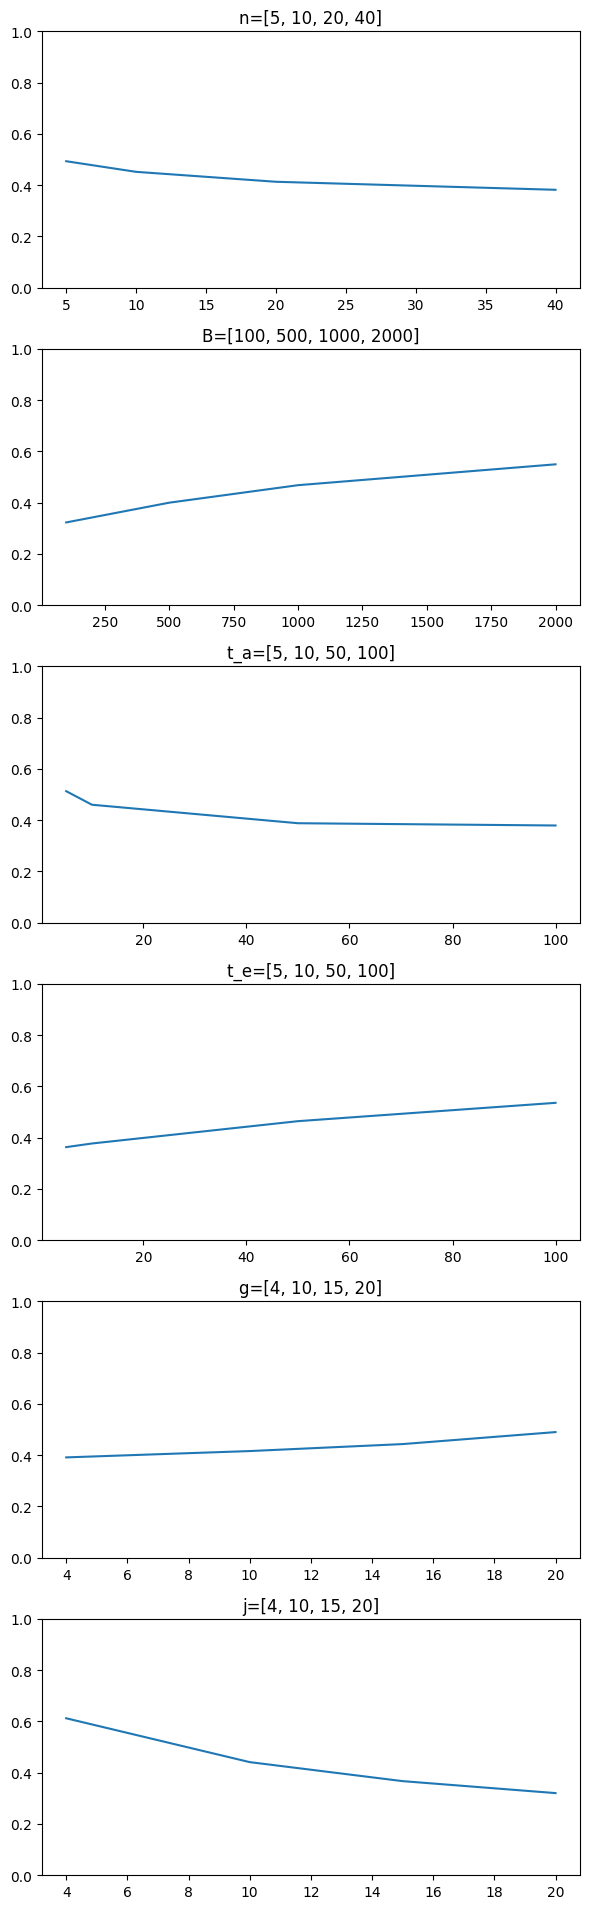

In [117]:

import matplotlib.pyplot as plt

params = {
    "n" : [5, 10, 20, 40],
    "B" : [100, 500, 1000, 2000],
    "t_a" : [5, 10, 50, 100],
    "t_e" : [5, 10, 50, 100],
    "g" : [4, 10, 15, 20],
    "j" : [4, 10, 15, 20]
    }

fig, axs = plt.subplots(6, 1, figsize=(6, 20))

def display(p_i):
    params_names = ['n', 'B', 't_a', 't_e', 'g', 'j']

    x = []

    for i in range(4):
        p_name = params_names[p_i]
        x.append(df2[df2[p_name]==params[p_name][i]]['P'].mean())
    axs[p_i].plot(params[p_name],x)
    axs[p_i].set_title(f'{p_name}={params[p_name]}')
    axs[p_i].set_ylim(0,1)

for p_i in range(6):
    display(p_i)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

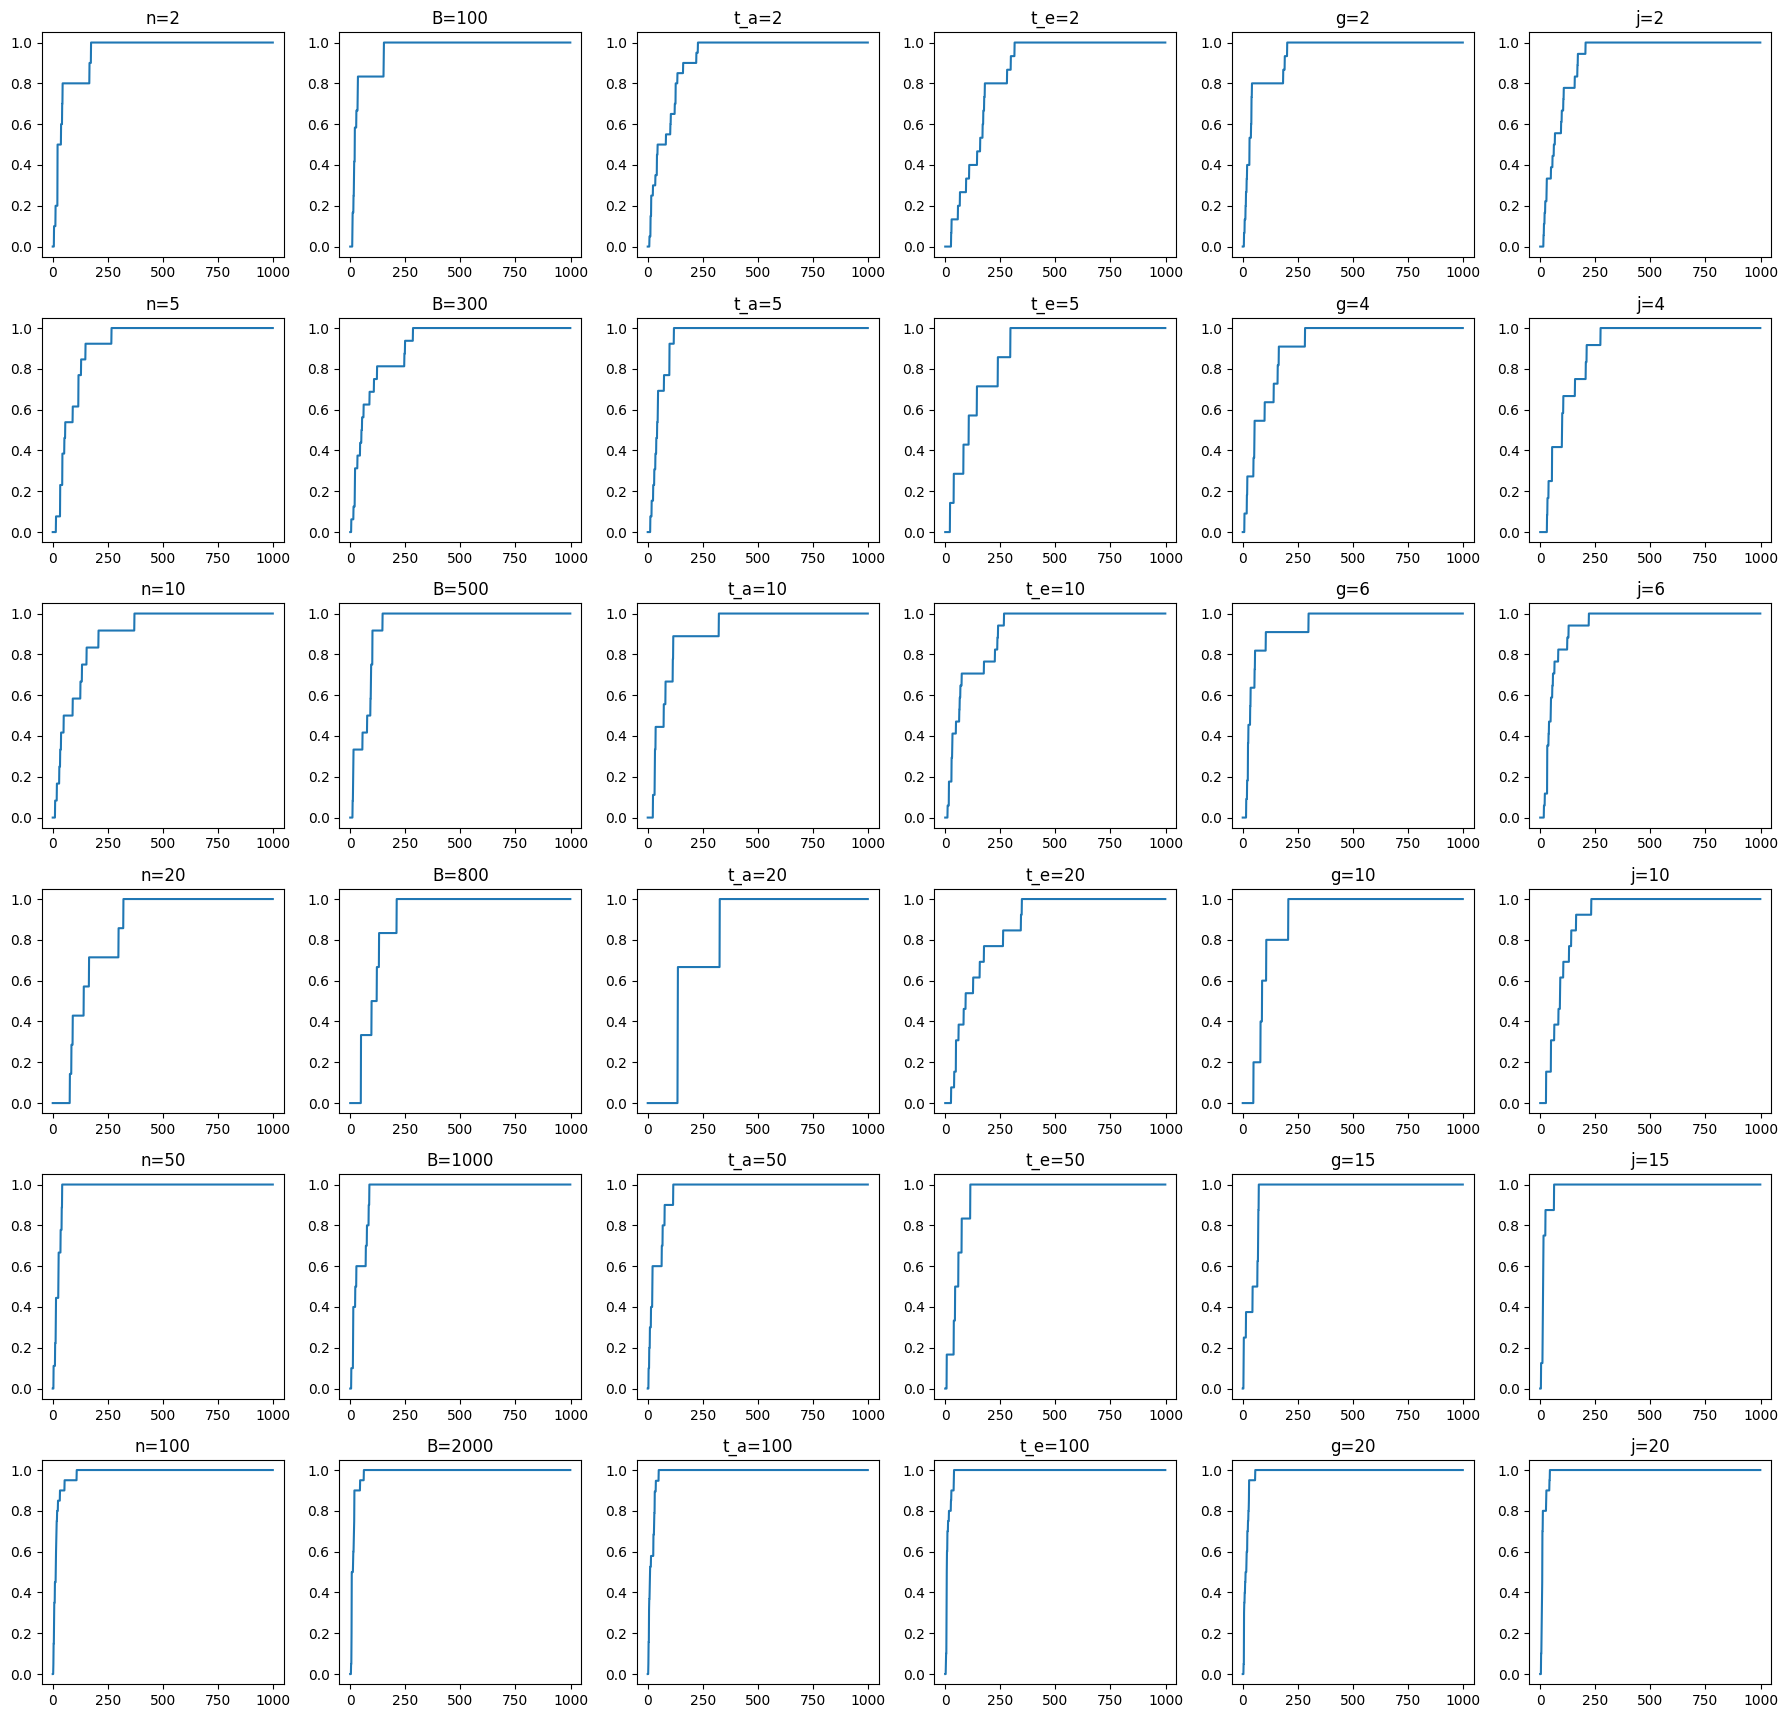

In [40]:

import matplotlib.pyplot as plt

params = {
    "n" : [2, 5, 10, 20, 50, 100],
    "B" : [100, 300, 500, 800, 1000, 2000],
    "t_a" : [2, 5, 10, 20, 50, 100],
    "t_e" : [2, 5, 10, 20, 50, 100],
    "g" : [2, 4, 6, 10, 15, 20],
    "j" : [2, 4, 6, 10, 15, 20]
    }



fig, axs = plt.subplots(6, 6, figsize=(18, 18))

def display(p_i):
    params_names = ['n', 'B', 't_a', 't_e', 'g', 'j']
    
    n = params['n']
    B = params['B']
    t_a = params['t_a']
    t_e = params['t_e']
    g = params['g']
    j = params['j']
    
    iters = 10

    default = 0

    def get_p(ar, p_ind, i):
        return ar[i] if p_ind == i else ar[default]

    for i in range(6):
        P = get_disrtib(get_p(n, 0, i), get_p(B, 1, i), get_p(t_a, 2, i), get_p(t_e, 3, i), get_p(g, 4, i), get_p(j, 5, i), iters)
        axs[i, p_i].plot(P)
        p_name = params_names[p_i]
        axs[i, p_i].set_title(f'{p_name}={params[p_name][i]}')

for p_i in range(6):
    display(p_i)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()